In [ ]:
"""
1. Look at spatial distribution of last sold properties
"""

In [952]:
import seaborn as sns
sns.set()

In [886]:
from datetime import datetime
import matplotlib
import matplotlib as mpl
import requests
import json
from gql import gql, Client
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize

def MANA_to_USD(mana_price, date):
    return float(mana_price[mana_price.Date == date].Close)

def convert_to_USD(row):
    return MANA_to_USD(mana_price, row.updatedAt_dt) * row.price

# Getting historical price of MANA in $USD
mana_price = pd.read_csv('MANA-USD.csv')

# Read downloaded data from parcel_transactions.csv
roads = pd.read_csv('roads.csv')
genesis = pd.read_csv('genesis.csv')

transactions = pd.read_csv('parcel_transactions.csv')


In [3]:
import get_marketplace_data as gmd

In [4]:
import importlib
importlib.reload(gmd)

<module 'get_marketplace_data' from '/home/jovyan/datacourse/Decentraland_playground/get_marketplace_data.py'>

In [328]:
gmd.get_parcels_from_estate('roads','0x9a6ebe7e2a7722f8200d0ffb63a1f6406a0d7dce')

estate 1 done, 172 parcels found
estate 2 done, 1110 parcels found
estate 3 done, 557 parcels found
estate 4 done, 406 parcels found
estate 5 done, 743 parcels found
estate 6 done, 581 parcels found
estate 7 done, 799 parcels found
estate 8 done, 289 parcels found
estate 9 done, 1244 parcels found
estate 10 done, 480 parcels found
estate 11 done, 10 parcels found
estate 12 done, 701 parcels found
estate 13 done, 730 parcels found
estate 14 done, 162 parcels found
estate 15 done, 1454 parcels found


In [252]:
gmd.get_parcels_from_estate('genesis','0x4eac6325e1dbf1ac90434d39766e164dca71139e',9)

estate 1 done, 400 parcels found
estate 2 done, 400 parcels found
estate 3 done, 400 parcels found
estate 4 done, 400 parcels found
estate 5 done, 400 parcels found
estate 6 done, 400 parcels found
estate 7 done, 400 parcels found
estate 8 done, 400 parcels found
estate 9 done, 380 parcels found


(0.0, 301.0, 0.0, 301.0)

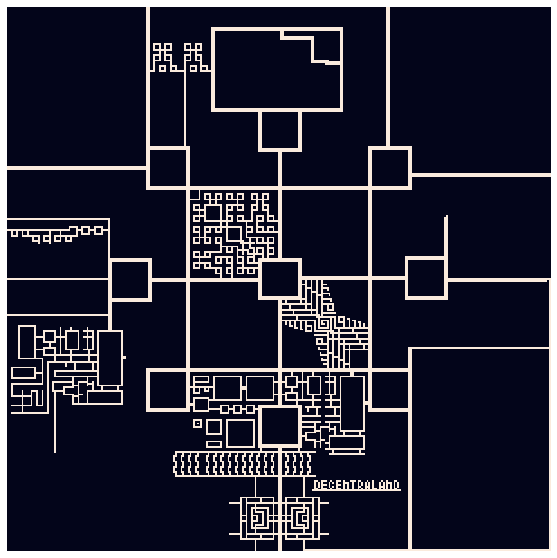

In [10]:
road_map = ~roads.pivot("y", "x",'pid').isna()
plt.figure(figsize=(10,10))
plot = sns.heatmap(road_map, square = True, cbar =False)
plt.gca().invert_yaxis()
plt.gca().axis('off')

In [887]:
from datetime import timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

START_DATE = datetime(2018, 10, 11)
END_DATE = datetime(2022, 4, 14)
all_dates = [sd for sd in daterange(START_DATE, END_DATE)]
baseline_data = pd.DataFrame(index=all_dates)


# Merging transaction data with MANA price and calculating mean price of parcels
#t = transactions.groupby('updatedAt_dt').count().index

number_sold = transactions.groupby('updatedAt_dt').count().id
number_sold = pd.DataFrame({'Date': number_sold.index, 'number_sold': number_sold.values.astype(int)})
number_sold.Date = number_sold.Date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
number_sold = number_sold.set_index('Date')

mean_price = transactions.groupby('updatedAt_dt').mean().price
mean_price = mean_price.to_frame().reset_index()
mean_price.updatedAt_dt = mean_price.updatedAt_dt.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
mean_price = mean_price.set_index('updatedAt_dt')

mana_price.Date = mana_price.Date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
mana_price = mana_price.set_index('Date')

baseline_data = baseline_data.join(mean_price, how='left').join(number_sold, how='left').join(mana_price.Close, how='left')
baseline_data.rename(columns={'Close':'mana_price'}, inplace=True)
baseline_data['price_usd'] = baseline_data.price * baseline_data.mana_price
baseline_data.interpolate(method='linear', inplace = True)

In [889]:
baseline_data

,price,number_sold,mana_price,price_usd
2018-10-11,32000.000000,1.0,0.067697,2166.304000
2018-10-12,23254.272727,11.0,0.068279,1587.778488
2018-10-13,23402.187500,16.0,0.068088,1593.408142
2018-10-14,30730.833333,6.0,0.067691,2080.200839
2018-10-15,22280.000000,5.0,0.069870,1556.703600
...,...,...,...,...
2022-04-09,5643.333333,3.0,2.339268,13201.269080
2022-04-10,5757.500000,4.0,2.272238,13082.410285
2022-04-11,4775.000000,4.0,2.055508,9815.050700
2022-04-12,4917.500000,4.0,2.153636,10590.505030


Text(0, 0.5, 'parcels sold')

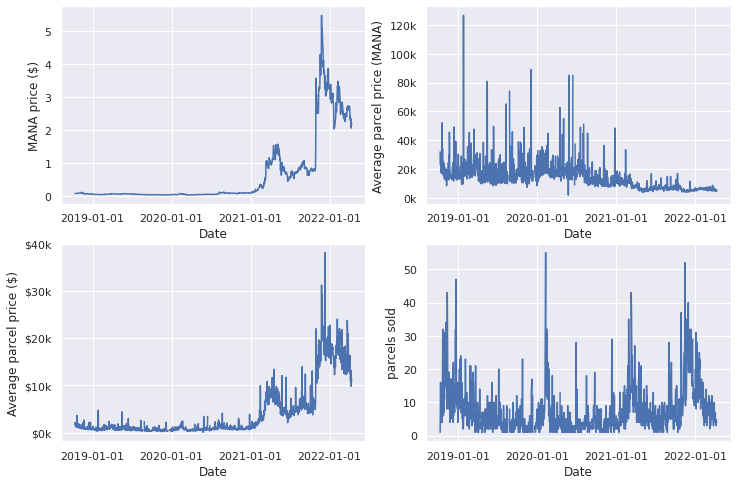

In [951]:
from matplotlib.ticker import FuncFormatter
fig, axs =plt.subplots(2,2, figsize=(12,8))

# Define some x-ticks to label the dates
t = [
 datetime.strptime('19-01','%y-%m'),
 datetime.strptime('20-01','%y-%m'),
 datetime.strptime('21-01','%y-%m'),
 datetime.strptime('22-01','%y-%m'),
]

axs[0,0].plot(baseline_data.mana_price)
axs[0,0].set_xticks(t)
axs[0,0].set_xlabel('Date')
axs[0,0].set_ylabel('MANA price ($)')

axs[0,1].plot(baseline_data.price)
axs[0,1].set_xticks(t)
axs[0,1].set_xlabel('Date')
axs[0,1].set_ylabel('Average parcel price (MANA)')
axs[0,1].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '%1.0fk' % (x*1e-3)))


axs[1,0].plot(baseline_data.price_usd)
axs[1,0].set_xticks(t)
axs[1,0].set_xlabel('Date')
axs[1,0].set_ylabel('Average parcel price ($)')
axs[1,0].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '$%1.0fk' % (x*1e-3)))


axs[1,1].plot(baseline_data.number_sold)
axs[1,1].set_xticks(t)
axs[1,1].set_xlabel('Date')
axs[1,1].set_ylabel('parcels sold')

#plt.vlines(x=datetime.strptime('21-10-28','%y-%m-%d'),ymin=0,ymax=60000,color='r', linestyle='--')

In [979]:
import pmdarima as pm

In [984]:
price_usd = baseline_data.price_usd.to_frame()

In [995]:
train = price_usd[:-90].values
test = price_usd[-90:].values

In [998]:
parcel_model = pm.auto_arima(train, start_p=1, start_q=1, suppress_warnings=True)

In [999]:
parcel_model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 1, 5),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [1000]:
parcel_in_sample = parcel_model.predict_in_sample()

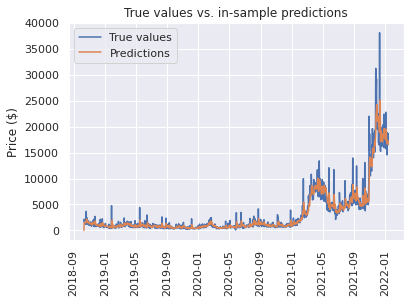

In [1009]:
fig, ax = plt.subplots()
plt.plot(price_usd[:-90].index, train, label="True values")
plt.plot(price_usd[:-90].index, parcel_in_sample, label="Predictions")
plt.title('True values vs. in-sample predictions')
plt.legend(loc='upper left')
plt.xticks(rotation=90)
ax.set_ylabel('Price ($)')
plt.show();

In [1003]:
from sklearn.metrics import r2_score, mean_squared_error

MSE: 1890410.3773819623
R2: 0.913332654478101


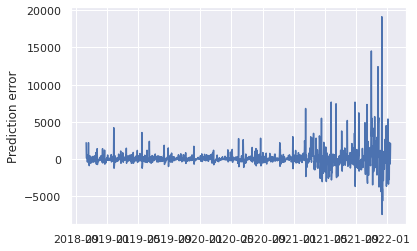

In [1019]:
plt.plot(price_usd[:-90].index, train.T.flatten() - parcel_in_sample)
plt.ylabel("Prediction error")
print("MSE: {}".format(mean_squared_error(train, parcel_in_sample)))
print("R2: {}".format(r2_score(train, parcel_in_sample)))

In [1026]:
test_predictions = parcel_model.predict(n_periods=90)

R^2: -12031.760378744153, MSE: 11151073.621744677


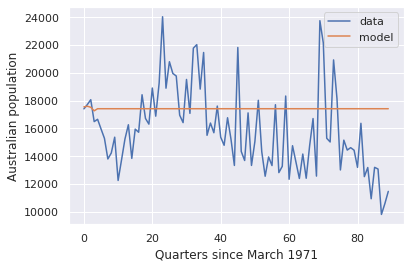

In [1028]:
plt.plot(test, label='data')
plt.plot(test_predictions, label='model')
plt.legend()
plt.ylabel("Australian population")
plt.xlabel("Quarters since March 1971")

r2 = r2_score(test_predictions, test)
mse = mean_squared_error(test_predictions, test)
print("R^2: {}, MSE: {}".format(r2, mse))

In [ ]:
baseline_data.price_usd

In [813]:
from pandas.plotting import autocorrelation_plot

In [1040]:
def plot_avg_parcel_price_history(period):
    test = pd.Series.rolling(baseline_data.price_usd, window=period).mean()
    plt.plot(baseline_data.price_usd)
    plt.plot(test)

In [1041]:
from ipywidgets import interact
interact(plot_avg_parcel_price_history, period=(1,50))

interactive(children=(IntSlider(value=25, description='period', max=50, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_avg_parcel_price_history(period)>

In [1048]:
baseline_data['price_usd_sm'] = pd.Series.rolling(baseline_data.price_usd, window=10).mean()

In [1060]:
baseline_data.price_usd_sm.interpolate(method='backfill', inplace = True)

In [1061]:
baseline_data

,price,number_sold,mana_price,price_usd,price_usd_sm
2018-10-11,32000.000000,1.0,0.067697,2166.304000,1843.232133
2018-10-12,23254.272727,11.0,0.068279,1587.778488,1843.232133
2018-10-13,23402.187500,16.0,0.068088,1593.408142,1843.232133
2018-10-14,30730.833333,6.0,0.067691,2080.200839,1843.232133
2018-10-15,22280.000000,5.0,0.069870,1556.703600,1843.232133
...,...,...,...,...,...
2022-04-09,5643.333333,3.0,2.339268,13201.269080,13809.369951
2022-04-10,5757.500000,4.0,2.272238,13082.410285,13601.757570
2022-04-11,4775.000000,4.0,2.055508,9815.050700,13138.751489
2022-04-12,4917.500000,4.0,2.153636,10590.505030,12736.008597


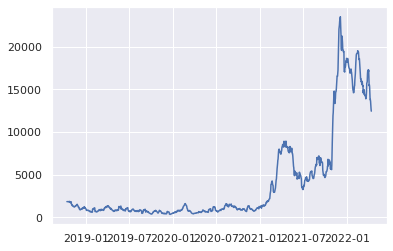

In [1063]:
plt.plot(baseline_data.price_usd_sm)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

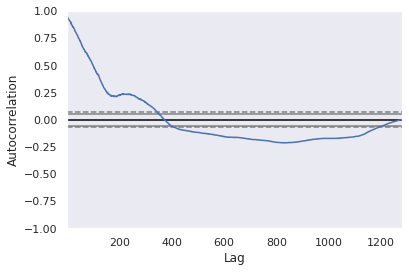

In [953]:
autocorrelation_plot(baseline_data.price_usd.fillna(0)) 

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

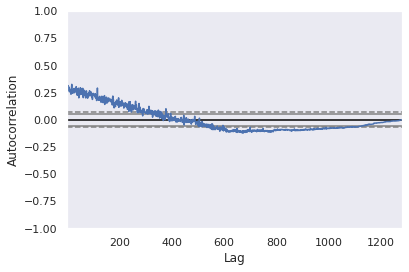

In [955]:
autocorrelation_plot(baseline_data.price.fillna(0))

In [52]:
# Read downloaded data from parcel_transactions.csv
ownerships = pd.read_csv('decentraland_ownership.csv')
owners = ownerships.owner.value_counts().index[0:10]
land = ownerships.owner.value_counts().values[0:10]
short = owners.to_series().apply(lambda a: a[0:5])

Text(0.5, 0, 'Owner')

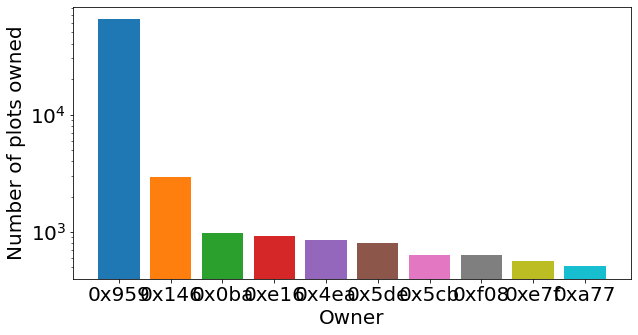

In [53]:
# Plot amount of parcels owned by top 10 land owners 
mpl.rcParams.update({'font.size':20})
plt.figure(figsize=(10,5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.bar(short,land,color=colors)
plt.yscale('log')
plt.ylabel('Number of plots owned')
plt.xlabel('Owner')

/opt/conda/envs/data3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/envs/data3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/envs/data3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/

(-150.0, 150.0, -165.0, 165.0)

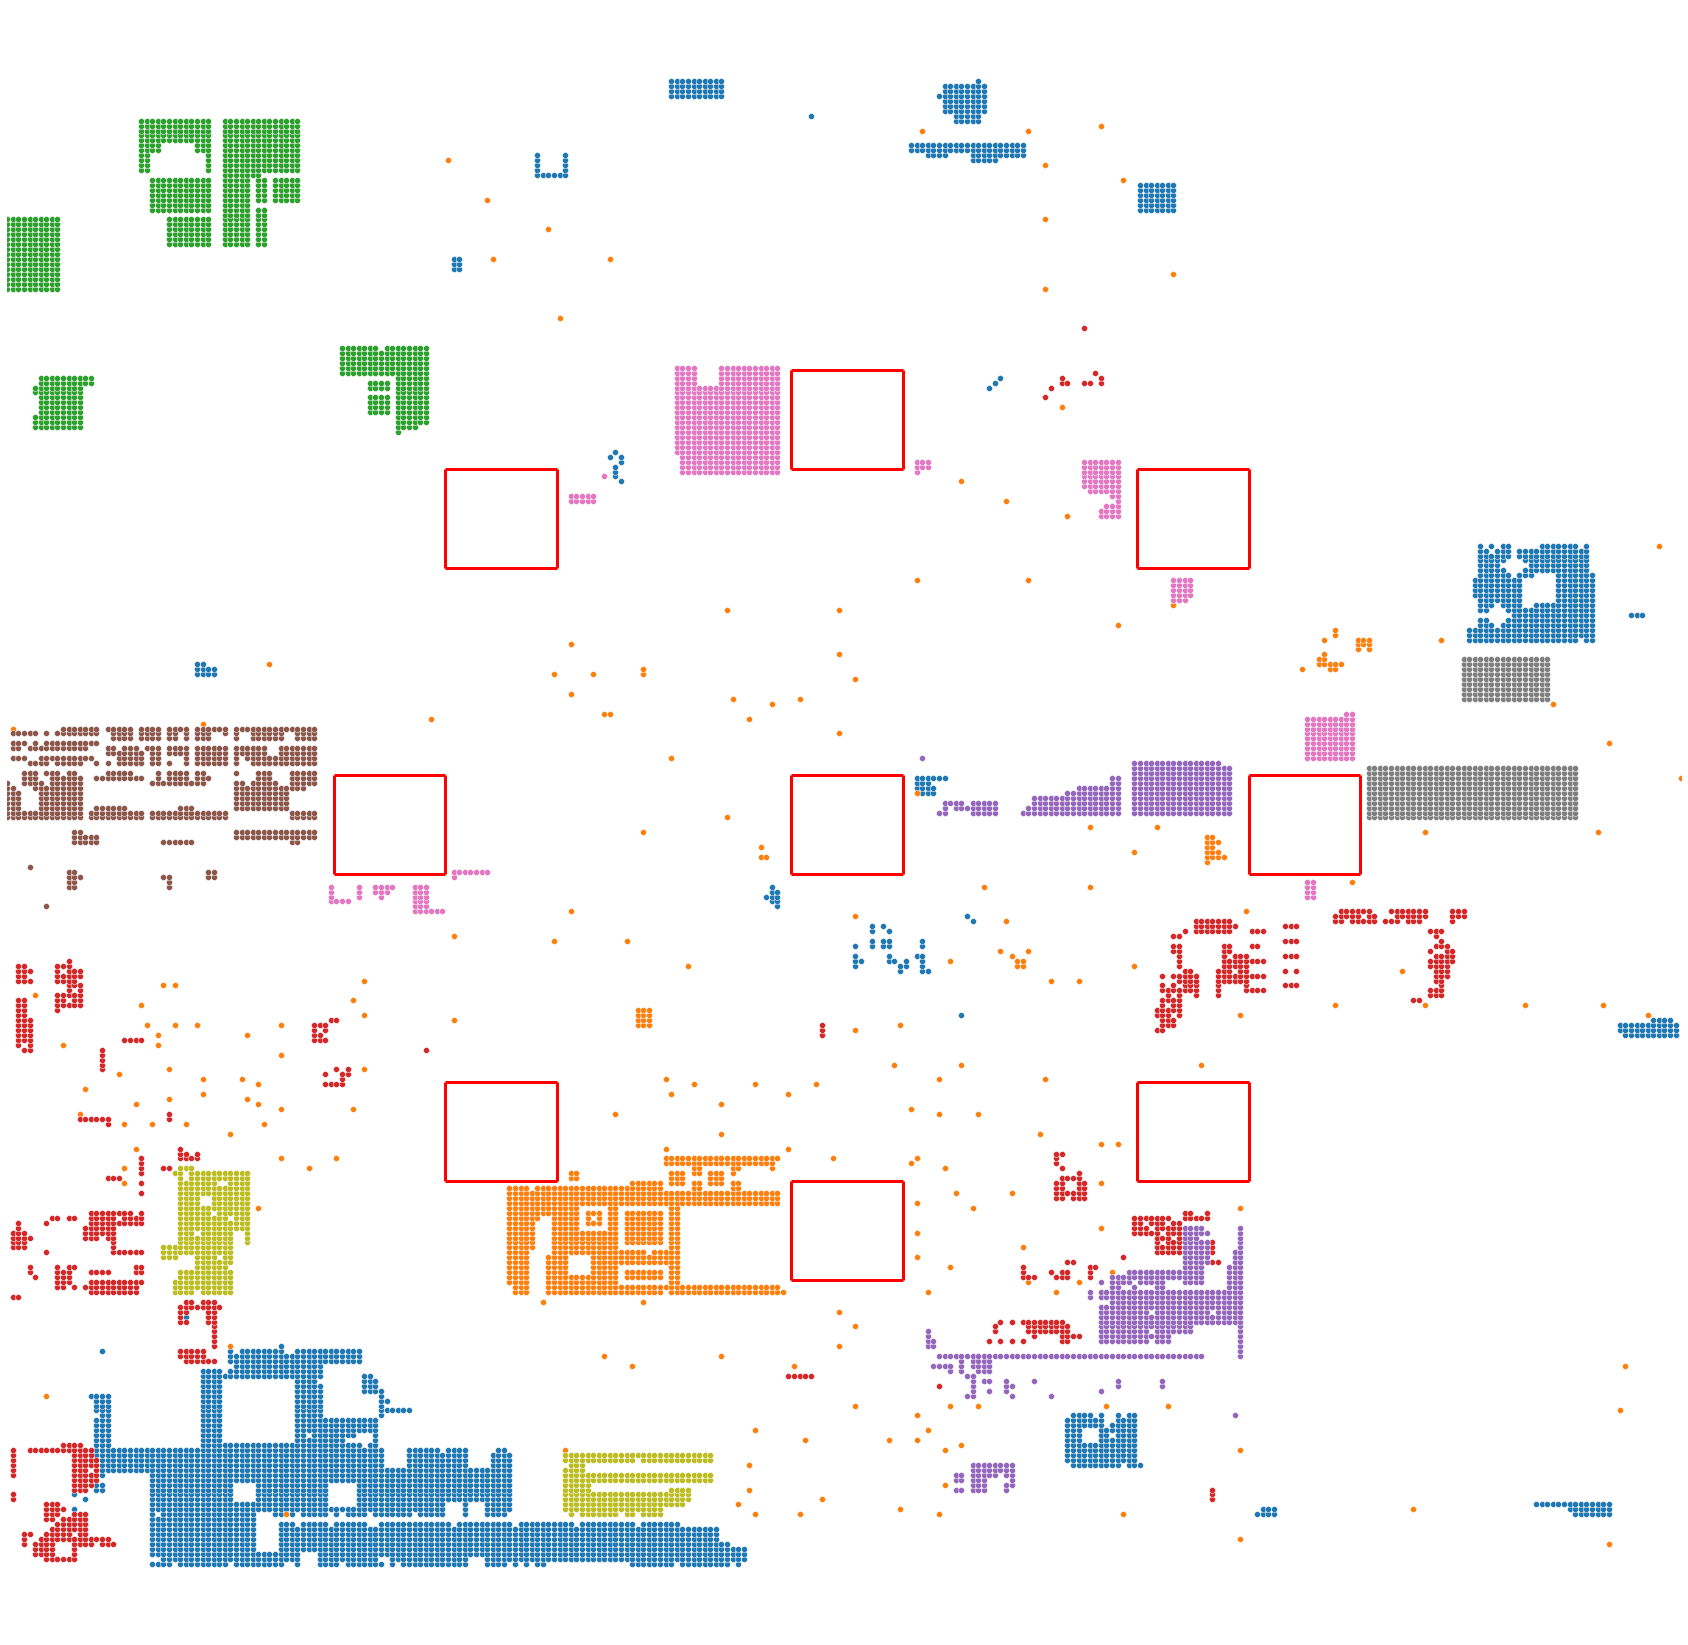

In [54]:
def plot_plaza(center_x, center_y, sq_size, color='r'):
    center_x += 0.5
    center_y -= 0.5
    plt.hlines(y= center_y -sq_size, xmin= center_x -sq_size, xmax= center_x + sq_size, color=color, linestyle='-', linewidth = 3)
    plt.vlines(x= center_x -sq_size, ymin= center_y -sq_size, ymax= center_y + sq_size, color=color, linestyle='-', linewidth = 3)
    plt.hlines(y= center_y +sq_size, xmin= center_x -sq_size, xmax= center_x + sq_size, color=color, linestyle='-', linewidth = 3)
    plt.vlines(x= center_x +sq_size, ymin= center_y -sq_size, ymax= center_y + sq_size, color=color, linestyle='-', linewidth = 3)

# Plot areas owned by top 10 landowners
plt.figure(figsize=(30,30))
for i in range(1,10):
    sns.scatterplot(ownerships.x[ownerships.owner == ownerships.owner.value_counts().index[i]], ownerships.y[ownerships.owner == ownerships.owner.value_counts().index[i]])

# Plotting the locations of the high footfall plazas    
plot_plaza(0,0,10)
plot_plaza(82,0,10)
plot_plaza(0,82,10)
plot_plaza(-82,0,10)
plot_plaza(0,-82,10)
plot_plaza(62,62,10)
plot_plaza(62,-62,10)
plot_plaza(-62,62,10)
plot_plaza(-62,-62,10)
plt.xlim(-150,150)
plt.axis('off')

In [13]:
last_sold = transactions.iloc[transactions.groupby('parcel_id').updatedAt.idxmax().values]

In [15]:
price_map = last_sold.pivot("y", "x", "price")

/tmp/ipykernel_657/3434477860.py:4: MatplotlibDeprecationWarning: Support for case-insensitive scales is deprecated since 3.5 and support will be removed two minor releases later.
  plt.yscale('Log')


Text(0, 0.5, 'Price(MANA)')

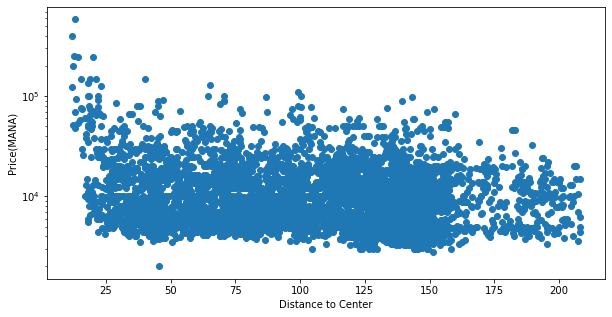

In [16]:
plt.figure(figsize=(10,5))
radius = np.sqrt(last_sold.x**2 + last_sold.y**2)
plt.scatter(radius,last_sold.price)
plt.yscale('Log')
plt.xlabel('Distance to Center')
plt.ylabel('Price(MANA)')

In [59]:
def plot_plazas(x,y,sq_size, color='r'):
    plot_plaza(x+0,y+0,10, color = color)
    plot_plaza(x+82,y+0,10, color = color)
    plot_plaza(x+0,y+82,10, color = color)
    plot_plaza(x-82,y+0,10, color = color)
    plot_plaza(x+0,y-82,10, color = color)
    plot_plaza(x+62,y+62,10, color = color)
    plot_plaza(x+62,y-62,10, color = color)
    plot_plaza(x-62,y+62,10, color = color)
    plot_plaza(x-62,y-62,10, color = color)

In [455]:
xx, yy = range(-150,151), range(-150,151)
XX,YY = np.meshgrid([x for x in xx], [y for y in yy])
XX = XX.flatten()
YY = YY.flatten()
XXYY = [i for i in zip(XX,YY)]

In [488]:
mask = pd.DataFrame({
    'XY': XXYY,
    'in_set': 1
})

In [487]:
def isinset(row, target_set):
    if row.XY in target_set:
        return 0
    return 1

In [489]:
mask['in_set'] = mask.apply(isinset, target_set = set(road_parcels), axis = 1)

In [490]:
mask[mask['in_set'] == 0]

,XY,in_set
137,"(-13, -150)",0
150,"(0, -150)",0
151,"(1, -150)",0
164,"(14, -150)",0
165,"(15, -150)",0
...,...,...
90210,"(61, 149)",0
90377,"(-73, 150)",0
90378,"(-72, 150)",0
90510,"(60, 150)",0


(0.0, 301.0, 301.0, 0.0)

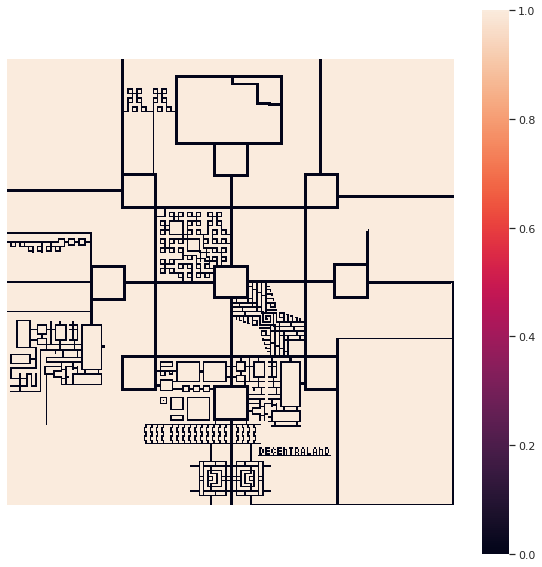

In [499]:
plt.figure(figsize=(10,10))
sns.heatmap(np.flip(mask.in_set.values.reshape(301,301), axis=0), square=True)
plt.axis('off')

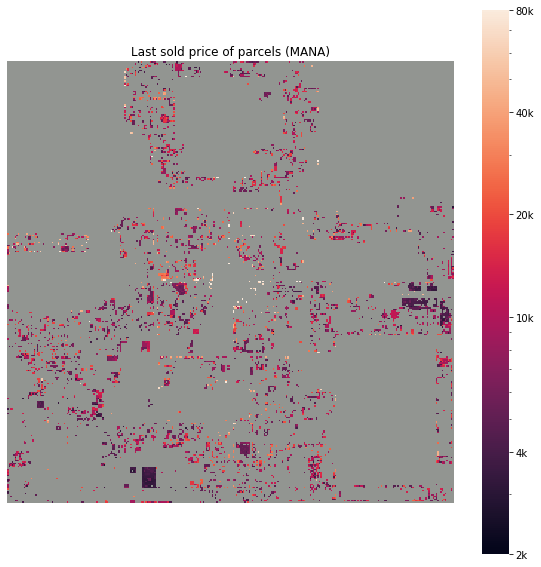

In [486]:
plt.figure(figsize=(10,10))
plot = sns.heatmap(price_map, norm=LogNorm(vmin=2000, vmax=80000), square = True)
plt.gca().invert_yaxis()
plt.gca().set_facecolor('xkcd:grey')
plt.yticks([])
plt.xticks([])
plt.xlabel("")
plt.ylabel("")
plt.title("Last sold price of parcels (MANA)")


#plot_plazas(150,150,10, color = 'b')

cbar = plot.collections[0].colorbar
ticks = np.array([2000., 4000., 10000., 20000., 40000., 80000.])
ticklabels = ["{:.0f}k".format(x) for x in ticks/1000]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticklabels)
#plt.axis('off')

In [32]:
#last_sold['price_usd'] 
test= last_sold.apply(convert_to_USD, axis='columns')

In [33]:
test

3876     1548.063600
7632    39332.260825
8940    19250.279224
2909      809.550000
2908      809.550000
            ...     
7734    44021.084592
3561     1594.023300
4595      616.920000
9280    14023.196050
8251    23315.836320
Length: 5966, dtype: float64

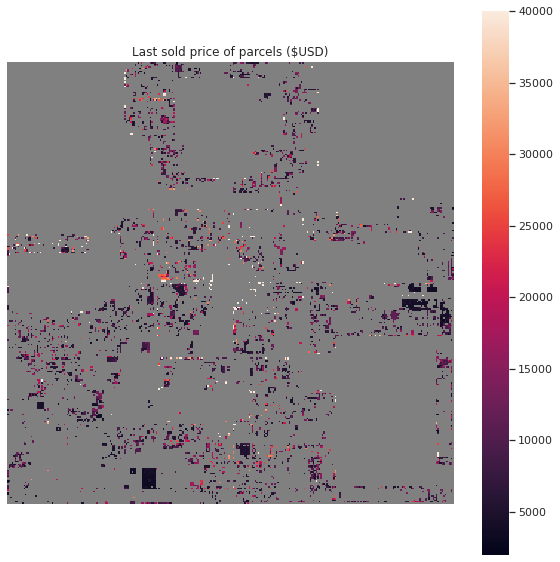

In [251]:
price_map_usd = last_sold.pivot("y", "x", "price")
plt.figure(figsize=(10,10))
plot = sns.heatmap(price_map_usd, square = True, vmin=2000, vmax=40000)
plt.gca().invert_yaxis()
plt.gca().set_facecolor('grey')
plt.yticks([])
plt.xticks([])
plt.xlabel("")
plt.ylabel("")
plt.title("Last sold price of parcels ($USD)")

#plot_plazas(150,150,10, color = 'b')

cbar = plot.collections[0].colorbar
#ticks = np.array([200., 1000., 2000., 10000., 20000., 80000.])
#ticklabels = ["${}k".format(x) for x in ticks/1000]
#cbar.set_ticks(ticks)
#cbar.set_ticklabels(ticklabels)

#plt.axis('off')

(-150.0, 150.0, -165.0066777041943, 165.0066777041943)

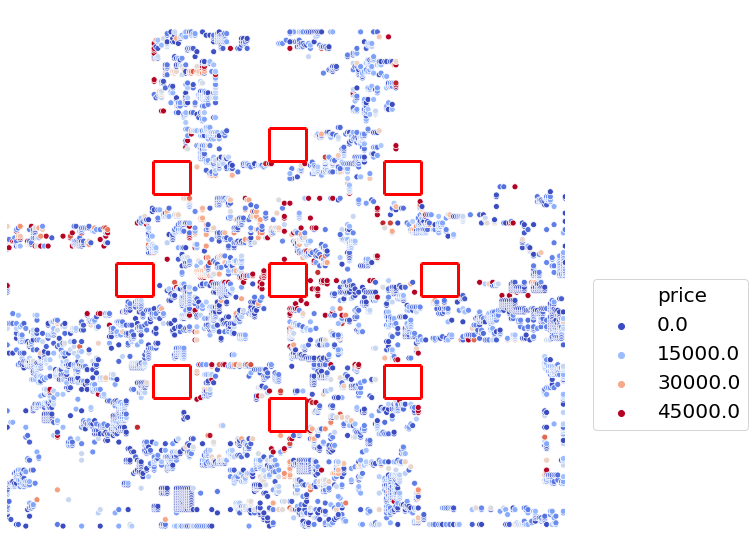

In [974]:
plt.figure(figsize=(10,10))
ax = plt.gca()
sns.scatterplot(data = last_sold, x="x", y="y",  hue=last_sold.price, palette = "coolwarm", hue_norm =(5000,40000), norm=LogNorm())
plt.legend(bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0.)
plt.axis('off')
plot_plaza(0,0,10)
plot_plaza(82,0,10)
plot_plaza(0,82,10)
plot_plaza(-82,0,10)
plot_plaza(0,-82,10)
plot_plaza(62,62,10)
plot_plaza(62,-62,10)
plot_plaza(-62,62,10)
plot_plaza(-62,-62,10)
plt.xlim(-150,150)
plt.axis('off')

In [9]:
# Read downloaded data from parcel_transactions.csv
estate_transactions = pd.read_csv('estate_transactions.csv')

In [150]:
estate_transactions

,category,price,id,buyer,updatedAt,nft,updatedAt_dt,parcels,estate_id
0,estate,100000.0,0xfa823daaf8ce6d40950d95fa407151b9d64e17e717e5...,0x0f08f5cf0905498ac6a8b5ff3d4c2acb5ff447f7,1539280016,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,2018-10-11,"[(-100, -107), (-99, -107)]",estate-0x959e104e1a4db6317fa58f8295f586e1a978c...
1,estate,100000.0,0xf52546e4d2fd7701ef16a36e199b596201fdc6066009...,0xef38f892e4722152fd8edb50cd84a96344fd47ce,1539280356,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,2018-10-11,"[(-100, -107), (-99, -107)]",estate-0x959e104e1a4db6317fa58f8295f586e1a978c...
2,estate,525000.0,0x0910cb1099a4e8a33e153b74aabfd9e5541c0ecde78b...,0x11f961e66bae258b09bf844b237447a973a960e8,1539350213,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,2018-10-12,"[(40, 64), (40, 65), (40, 66), (40, 67), (40, ...",estate-0x959e104e1a4db6317fa58f8295f586e1a978c...
3,estate,99000.0,0xd70c22996842eb0e9898d604a5f9c6cbe54b9fea26a7...,0x0ed1c03d04c1fbb33a0f25ef6147ab5a73d811a7,1539364639,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,2018-10-12,[],estate-0x959e104e1a4db6317fa58f8295f586e1a978c...
4,estate,33999.0,0xc166dc81d57408d3f78561d23a628bf203d873c82e62...,0xf902d068920234957d2908b8b0156e61c0bea2c2,1539372861,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,2018-10-12,[],estate-0x959e104e1a4db6317fa58f8295f586e1a978c...
...,...,...,...,...,...,...,...,...,...
1903,estate,22300.0,0x7f428392c8b2db2003f5edf192303c59a44f8607fc1f...,0x4a1bf5d5f3a824c4353614369451d5233d4d6f06,1649434093,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,2022-04-08,"[(-120, -31), (-120, -30), (-119, -31), (-119,...",estate-0x959e104e1a4db6317fa58f8295f586e1a978c...
1904,estate,30000.0,0x3c3da8a06997c91ed16a3a9ecce26f4df2d3a9be7599...,0x1f5da4278ffdf8d816da17316b00b239976d8232,1649436497,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,2022-04-08,"[(-27, 27), (-27, 28), (-26, 27), (-26, 28)]",estate-0x959e104e1a4db6317fa58f8295f586e1a978c...
1905,estate,37000.0,0x7bbe02297d70b9826d455e6dc3b152358735a6e84b4c...,0x24167305a3667023ea565f971d72509ef758ac78,1649490240,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,2022-04-09,"[(43, 82), (43, 83), (44, 82), (44, 83)]",estate-0x959e104e1a4db6317fa58f8295f586e1a978c...
1906,estate,9888.0,0x150227fd63584b870d1a375855bf13c6f0972304a100...,0x5ce213893956bbf4249a7f8a079331280065eec6,1649642512,{'estate': {'id': 'estate-0x959e104e1a4db6317f...,2022-04-11,"[(-127, 10), (-126, 10)]",estate-0x959e104e1a4db6317fa58f8295f586e1a978c...


In [446]:
last_sold_estate = estate_transactions.iloc[estate_transactions.groupby('estate_id').updatedAt.idxmax().values]
last_sold_estate = last_sold_estate[last_sold_estate.parcels != '[]']

In [468]:
def get_parcels(row):
    estate_parcel_coords_str = row.parcels
    parcels = [x.strip("[()] ") for x in estate_parcel_coords_str.split("),")]
    estate_parcel_coords = [(int(s.split(',')[0]), int(s.split(',')[1])) for s in parcels]
    parcel_breakdown_df = pd.DataFrame(columns=['estate_id','x','y','estate_size','total_price','price','updatedAt','updatedAt_dt','buyer'])

    for coord in estate_parcel_coords:
        entry = {
            'estate_id':row.estate_id, 
            'x':coord[0], 
            'y':coord[1], 
            'estate_size': len(estate_parcel_coords), 
            'total_price': row.price,
            'price': row.price/len(estate_parcel_coords),
            'updatedAt': row.updatedAt,
            'updatedAt_dt': row.updatedAt_dt,
            'buyer': row.buyer
        }
        parcel_breakdown_df = parcel_breakdown_df.append(entry, ignore_index=True)
    return parcel_breakdown_df

In [680]:
parcel_breakdown = pd.DataFrame(columns=['estate_id','x','y','estate_size','total_price','price','updatedAt','updatedAt_dt','buyer'])
i = 1
for index, row in last_sold_estate.iterrows():
    parcel_breakdown = parcel_breakdown.append(get_parcels(row), ignore_index=True)
    if (i % 100 == 0):
        print('first {} rows done!'.format(i))
    i = i+1

first 100 rows done!
first 200 rows done!
first 300 rows done!
first 400 rows done!
first 500 rows done!
first 600 rows done!
first 700 rows done!
first 800 rows done!


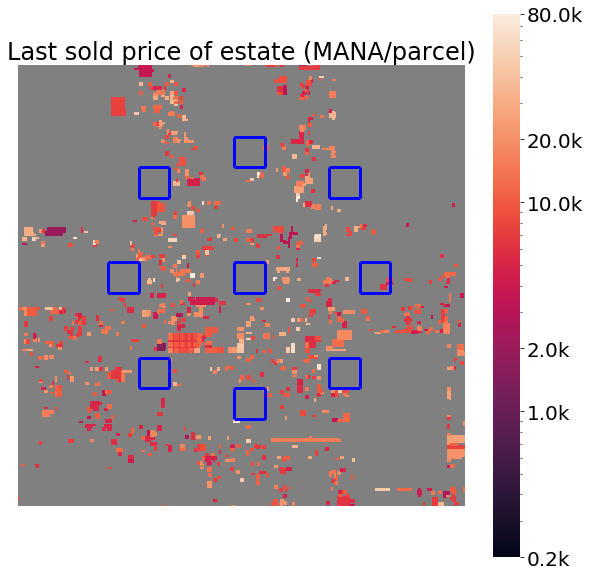

In [684]:
price_map_mana = parcel_breakdown.pivot("y", "x", "price")
plt.figure(figsize=(10,10))
plot = sns.heatmap(price_map_mana, norm=LogNorm(), square = True, vmin=200, vmax=80000)
plt.gca().invert_yaxis()
plt.gca().set_facecolor('grey')
plt.yticks([])
plt.xticks([])
plt.xlabel("")
plt.ylabel("")
plt.title("Last sold price of estate (MANA/parcel)")

plot_plazas(150,150,10, color = 'b')

cbar = plot.collections[0].colorbar
ticks = np.array([200., 1000., 2000., 10000., 20000., 80000.])
ticklabels = ["{}k".format(x) for x in ticks/1000]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticklabels)


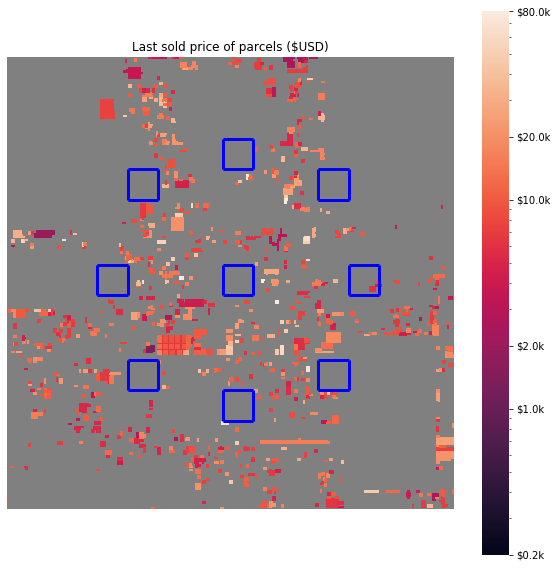

In [651]:
parcel_breakdown['price_usd'] = parcel_breakdown.apply(convert_to_USD, axis='columns')
price_map_usd = parcel_breakdown.pivot("y", "x", "price")
plt.figure(figsize=(10,10))
plot = sns.heatmap(price_map_mana, norm=LogNorm(), square = True, vmin=200, vmax=80000)
plt.gca().invert_yaxis()
plt.gca().set_facecolor('grey')
plt.yticks([])
plt.xticks([])
plt.xlabel("")
plt.ylabel("")
plt.title("Last sold price of parcels ($USD)")

plot_plazas(150,150,10, color = 'b')

cbar = plot.collections[0].colorbar
ticks = np.array([200., 1000., 2000., 10000., 20000., 80000.])
ticklabels = ["${}k".format(x) for x in ticks/1000]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticklabels)

In [34]:
from datetime import datetime
datetime.fromtimestamp(1539287969).strftime("%A, %B %d, %Y %I:%M:%S")


'Thursday, October 11, 2018 07:59:29'

In [17]:
cleaned_transactions = pd.DataFrame({'parcel_id': transactions.parcel_id,
                                     'category': transactions.category, 
                                     'price': transactions.price,
                                     'updatedAt': transactions.updatedAt,
                                     'updatedAt_dt': transactions.updatedAt_dt.apply(lambda x: datetime.strptime(x, '%Y-%m-%d')),
                                     'owner': transactions.owner,
                                     'x': transactions.x,
                                     'y': transactions.y 
                                    })

In [22]:
price_usd = transactions.apply(convert_to_USD, axis='columns')

In [23]:
cleaned_transactions['price_usd'] = price_usd

In [24]:
transactions

,Unnamed: 0,category,status,price,id,updatedAt,nft,owner,name,estate,parcel,updatedAt_dt,x,y,parcel_id
0,0,parcel,sold,32000.0,0xbc79ff3843d8678425df0e8b0a7b1a67688720b78a8b...,1539287969,{'owner': {'id': '0x959e104e1a4db6317fa58f8295...,0x959e104e1a4db6317fa58f8295f586e1a978c297,NEAR VEGAS CITY - fordcotterill18@gmail.com,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2018-10-11,-70,145,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
1,1,parcel,sold,30000.0,0x3b2e69fe4806f1bf72aa060681c5d46e58952339854c...,1539329807,{'owner': {'id': '0x8668272b4776c423dde82314d5...,0x8668272b4776c423dde82314d5e0447fd4654aff,NaN,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2018-10-12,-27,-21,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
2,2,parcel,sold,15000.0,0x487340425511b41b2bbda39af565b4c9d74bb1157209...,1539334568,{'owner': {'id': '0x95606705b7452e96a9e88901ee...,0x95606705b7452e96a9e88901ee418ef4e3d19847,Peet's Place,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2018-10-12,65,-28,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
3,3,parcel,sold,15999.0,0x8e42e12fab25f618671e7f61a7c48bcce4bf5f790969...,1539337159,{'owner': {'id': '0x1bdd4874e4be949dfd237ca97e...,0x1bdd4874e4be949dfd237ca97e66c05aa4de355d,Coodz house,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2018-10-12,-44,101,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
4,4,parcel,sold,20000.0,0x9463c0aceb0c5f0a4884eedef9a2c03763b051ba5584...,1539344152,{'owner': {'id': '0x8e190b487e64ebab9cbc400a0d...,0x8e190b487e64ebab9cbc400a0d1d2944ef279467,Excellent land sat right on Dragon city district!,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2018-10-12,84,-139,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9542,542,parcel,sold,7900.0,0xf66d10e381b96b7904d7ec8e95e56e31d60889f8e544...,1649793558,{'owner': {'id': '0x3dea6c7bc613c926e139e61432...,0x3dea6c7bc613c926e139e61432386ae8fc9c3d4c,NaN,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2022-04-12,19,17,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
9543,543,parcel,sold,5555.0,0x2e9a033401a12c33e14e08f6a89f0098b6be35d9c7af...,1649813981,{'owner': {'id': '0xefe0821cbb22716a906aa602b9...,0xefe0821cbb22716a906aa602b97810c4cc78a631,NISOVERSE,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2022-04-13,149,-69,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
9544,544,parcel,sold,3950.0,0x2078af98ae35ca2dbe302734e3defd59e2eb039c3618...,1649816999,{'owner': {'id': '0x7823365ab55d6cefac58a08756...,0x7823365ab55d6cefac58a08756d1732892e4c933,NaN,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2022-04-13,120,-5,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
9545,545,parcel,sold,4850.0,0x8fb303abece9ba2e129bddf88a424a000c23e140792d...,1649821339,{'owner': {'id': '0x1b81925e7f9ee7fa226d5a50bf...,0x1b81925e7f9ee7fa226d5a50bf69dc957c3181b3,NaN,NaN,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2022-04-13,128,-36,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...


In [100]:
cleaned_transactions

,parcel_id,category,price,updatedAt,updatedAt_dt,owner,x,y,price_usd
0,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,32000.0,1539287969,2018-10-11,0x959e104e1a4db6317fa58f8295f586e1a978c297,-70,145,2166.304000
1,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,30000.0,1539329807,2018-10-12,0x8668272b4776c423dde82314d5e0447fd4654aff,-27,-21,2048.370000
2,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,15000.0,1539334568,2018-10-12,0x95606705b7452e96a9e88901ee418ef4e3d19847,65,-28,1024.185000
3,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,15999.0,1539337159,2018-10-12,0x1bdd4874e4be949dfd237ca97e66c05aa4de355d,-44,101,1092.395721
4,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,20000.0,1539344152,2018-10-12,0x8e190b487e64ebab9cbc400a0d1d2944ef279467,84,-139,1365.580000
...,...,...,...,...,...,...,...,...,...
9542,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,7900.0,1649793558,2022-04-12,0x3dea6c7bc613c926e139e61432386ae8fc9c3d4c,19,17,17013.724400
9543,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,5555.0,1649813981,2022-04-13,0xefe0821cbb22716a906aa602b97810c4cc78a631,149,-69,12228.143730
9544,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,3950.0,1649816999,2022-04-13,0x7823365ab55d6cefac58a08756d1732892e4c933,120,-5,8695.079700
9545,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,4850.0,1649821339,2022-04-13,0x1b81925e7f9ee7fa226d5a50bf69dc957c3181b3,128,-36,10676.237100


TypeError: strptime() argument 1 must be str, not Series

In [95]:
datetime(2020,1,1)

datetime.datetime(2020, 1, 1, 0, 0)

In [104]:
cleaned_transactions[cleaned_transactions.updatedAt_dt < datetime(2019,1,1)]

,parcel_id,category,price,updatedAt,updatedAt_dt,owner,x,y,price_usd
0,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,32000.0,1539287969,2018-10-11,0x959e104e1a4db6317fa58f8295f586e1a978c297,-70,145,2166.304000
1,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,30000.0,1539329807,2018-10-12,0x8668272b4776c423dde82314d5e0447fd4654aff,-27,-21,2048.370000
2,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,15000.0,1539334568,2018-10-12,0x95606705b7452e96a9e88901ee418ef4e3d19847,65,-28,1024.185000
3,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,15999.0,1539337159,2018-10-12,0x1bdd4874e4be949dfd237ca97e66c05aa4de355d,-44,101,1092.395721
4,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,20000.0,1539344152,2018-10-12,0x8e190b487e64ebab9cbc400a0d1d2944ef279467,84,-139,1365.580000
...,...,...,...,...,...,...,...,...,...
1228,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,20000.0,1546248883,2018-12-31,0x959e104e1a4db6317fa58f8295f586e1a978c297,111,-2,908.440000
1229,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,9500.0,1546259615,2018-12-31,0x34b6d86fba8e66ca07438298c59e77e74e321604,146,-30,431.509000
1230,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,9900.0,1546268377,2018-12-31,0x34b6d86fba8e66ca07438298c59e77e74e321604,146,-30,449.677800
1231,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,9550.0,1546270546,2018-12-31,0xba19945798d02e0441b2d1c3ecfdee84b3e32683,145,-30,433.780100


Text(0, 0.5, '# sales per month')

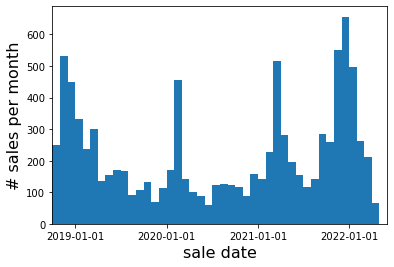

In [126]:
db = [datetime(y,m,1)  for y in [2017,2018,2019,2020,2021,2022] for m in range(1,13)]
plt.hist(cleaned_transactions.updatedAt_dt,bins=db)
plt.xlim(datetime(2018,10,1),datetime(2022,6,1))
plt.xticks([datetime(y,1,1)  for y in [2019,2020,2021,2022]])
plt.xlabel('sale date', fontsize=16)
plt.ylabel('# sales per month', fontsize=16)

In [265]:
def calculate_dist(X0, X1):
    '''
    This function takes a list of subject coords of parcels X1 and 
    returns the nearest distance to a list of coords of target parcels X0
    e.g. calculate_dist(road_parcels, sold_parcels)
    '''
    neigh = NearestNeighbors(n_neighbors=1, radius=10.0, algorithm = 'kd_tree')
    neigh.fit(X0)
    dist, _ = neigh.kneighbors(X1)
    return dist
    

from sklearn.neighbors import NearestNeighbors
road_parcels = [i for i in zip(roads.x, roads.y)]
genesis_parcels = [i for i in zip(genesis.x, genesis.y)]
sold_parcels_xy = [i for i in zip(cleaned_transactions.x, cleaned_transactions.y)]
cleaned_transactions['dist_road'] = calculate_dist(road_parcels, sold_parcels_xy)
cleaned_transactions['dist_genesis'] = calculate_dist(genesis_parcels, sold_parcels_xy)
cleaned_transactions['dist_center'] = np.sqrt(np.sum(np.array(sold_parcels_xy)**2,1))


In [52]:
x, y = np.linspace(-150,150,301), np.linspace(-150,150,301)
X,Y = np.meshgrid(x,y)
X = X.flatten()
Y = Y.flatten()
R = np.sqrt(X**2 + Y**2)
XY = [i for i in zip(X, Y)]

(-165.0, 165.0, -165.0, 165.0)

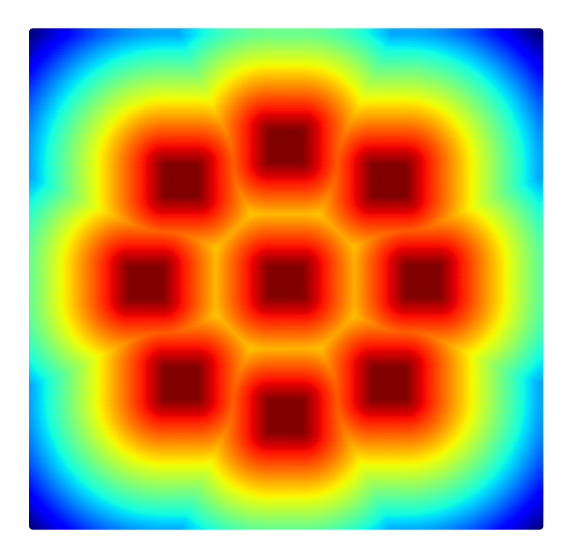

In [264]:
plt.figure(figsize=(10,10))
#plt.scatter(cleaned_transactions.x, cleaned_transactions.y, cmap = 'jet', c=-cleaned_transactions.dist_road)
plt.scatter(X, Y, cmap = 'jet', c=-calculate_dist(genesis_parcels, XY))
plt.axis('off')


In [29]:
cleaned_transactions

,parcel_id,category,price,updatedAt,updatedAt_dt,owner,x,y,price_usd,dist_road,dist_genesis,dist_center
0,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,32000.0,1539287969,2018-10-11,0x959e104e1a4db6317fa58f8295f586e1a978c297,-70,145,2166.304000,2.000000,74.000000,161.012422
1,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,30000.0,1539329807,2018-10-12,0x8668272b4776c423dde82314d5e0447fd4654aff,-27,-21,2048.370000,18.867962,39.824616,34.205263
2,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,15000.0,1539334568,2018-10-12,0x95606705b7452e96a9e88901ee418ef4e3d19847,65,-28,1024.185000,12.206556,20.248457,70.774289
3,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,15999.0,1539337159,2018-10-12,0x1bdd4874e4be949dfd237ca97e66c05aa4de355d,-44,101,1092.395721,7.000000,31.048349,110.168053
4,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,20000.0,1539344152,2018-10-12,0x8e190b487e64ebab9cbc400a0d1d2944ef279467,84,-139,1365.580000,11.000000,69.231496,162.409975
...,...,...,...,...,...,...,...,...,...,...,...,...
9542,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,7900.0,1649793558,2022-04-12,0x3dea6c7bc613c926e139e61432386ae8fc9c3d4c,19,17,17013.724400,9.219544,48.104054,25.495098
9543,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,5555.0,1649813981,2022-04-13,0xefe0821cbb22716a906aa602b97810c4cc78a631,149,-69,12228.143730,1.000000,78.000000,164.201096
9544,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,3950.0,1649816999,2022-04-13,0x7823365ab55d6cefac58a08756d1732892e4c933,120,-5,8695.079700,4.000000,29.000000,120.104121
9545,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,4850.0,1649821339,2022-04-13,0x1b81925e7f9ee7fa226d5a50bf69dc957c3181b3,128,-36,10676.237100,2.000000,45.803930,132.966161


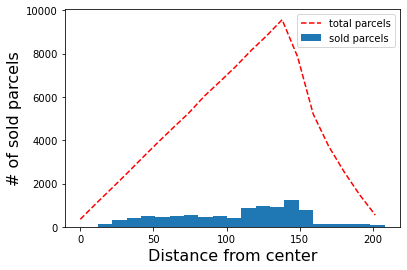

In [195]:
norm = np.histogram(R,bins=20)
plt.hist(cleaned_transactions.dist_center,bins=20)
plt.xlabel('Distance from center', fontsize=16)
plt.ylabel('# of sold parcels', fontsize=16)
plt.plot(norm[1][:-1],norm[0],'r--')
plt.legend(['total parcels','sold parcels'])
#plt.yscale('log')

Text(0, 0.5, '# of sold parcels')

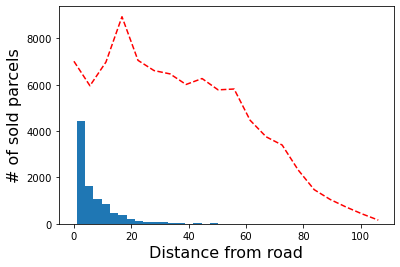

In [193]:
norm_roads = calculate_dist(road_parcels, [i for i in zip(X,Y)])
norm = np.histogram(norm_genesis_dist,bins=20)
plt.plot(norm[1][:-1], norm[0], 'r--')
plt.hist(cleaned_transactions.dist_road,bins=20)
plt.xlabel('Distance from road', fontsize=16)
plt.ylabel('# of sold parcels', fontsize=16)
#plt.yscale('log')

Text(0, 0.5, '# of sold parcels')

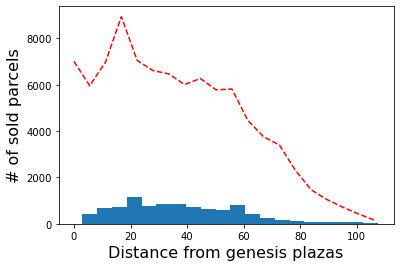

In [191]:
norm_genesis_dist = calculate_dist(genesis_parcels, [i for i in zip(X,Y)])
norm = np.histogram(norm_genesis_dist,bins=20)
plt.plot(norm[1][:-1], norm[0], 'r--')
plt.hist(cleaned_transactions.dist_genesis,bins=20)
plt.xlabel('Distance from genesis plazas', fontsize=16)
plt.ylabel('# of sold parcels', fontsize=16)

In [198]:
import seaborn as sns
sns.set()

In [1064]:
cleaned_transactions

,parcel_id,category,price,updatedAt,updatedAt_dt,owner,x,y,price_usd,dist_road,dist_genesis,dist_center
0,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,32000.0,1539287969,2018-10-11,0x959e104e1a4db6317fa58f8295f586e1a978c297,-70,145,2166.304000,2.000000,74.000000,161.012422
1,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,30000.0,1539329807,2018-10-12,0x8668272b4776c423dde82314d5e0447fd4654aff,-27,-21,2048.370000,18.867962,21.633308,34.205263
2,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,15000.0,1539334568,2018-10-12,0x95606705b7452e96a9e88901ee418ef4e3d19847,65,-28,1024.185000,12.206556,20.248457,70.774289
3,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,15999.0,1539337159,2018-10-12,0x1bdd4874e4be949dfd237ca97e66c05aa4de355d,-44,101,1092.395721,7.000000,31.048349,110.168053
4,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,20000.0,1539344152,2018-10-12,0x8e190b487e64ebab9cbc400a0d1d2944ef279467,84,-139,1365.580000,11.000000,69.231496,162.409975
...,...,...,...,...,...,...,...,...,...,...,...,...
9542,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,7900.0,1649793558,2022-04-12,0x3dea6c7bc613c926e139e61432386ae8fc9c3d4c,19,17,17013.724400,9.219544,12.041595,25.495098
9543,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,5555.0,1649813981,2022-04-13,0xefe0821cbb22716a906aa602b97810c4cc78a631,149,-69,12228.143730,1.000000,78.000000,164.201096
9544,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,3950.0,1649816999,2022-04-13,0x7823365ab55d6cefac58a08756d1732892e4c933,120,-5,8695.079700,4.000000,29.000000,120.104121
9545,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...,parcel,4850.0,1649821339,2022-04-13,0x1b81925e7f9ee7fa226d5a50bf69dc957c3181b3,128,-36,10676.237100,2.000000,45.803930,132.966161


In [1066]:
baseline_data.price_usd_sm

2018-10-11     1843.232133
2018-10-12     1843.232133
2018-10-13     1843.232133
2018-10-14     1843.232133
2018-10-15     1843.232133
                  ...     
2022-04-09    13809.369951
2022-04-10    13601.757570
2022-04-11    13138.751489
2022-04-12    12736.008597
2022-04-13    12439.546790
Name: price_usd_sm, Length: 1281, dtype: float64

In [1073]:
cleaned_transactions = cleaned_transactions.join(baseline_data.price_usd_sm, on=cleaned_transactions.updatedAt_dt)

In [1076]:
cleaned_transactions.rename(columns={'price_usd_sm':'avg_parcel_price'}, inplace = True)

In [1078]:
cleaned_transactions['norm_price_usd'] = cleaned_transactions.price_usd/cleaned_transactions.avg_parcel_price

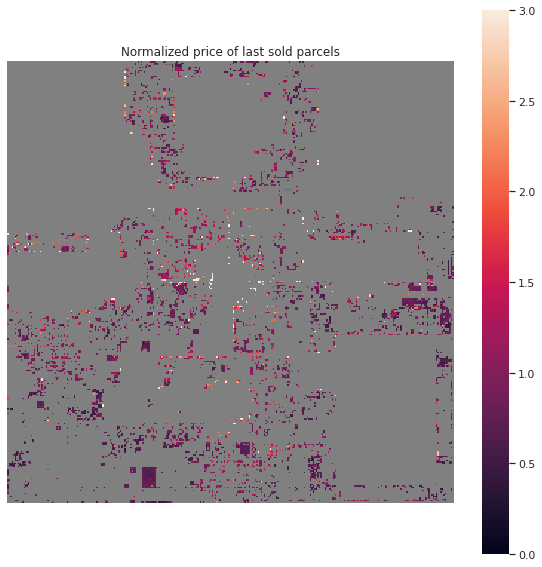

In [1101]:
last_sold = cleaned_transactions.iloc[cleaned_transactions.groupby('parcel_id').updatedAt.idxmax().values]
norm_price_map_usd = last_sold.pivot("y", "x", "norm_price_usd")
plt.figure(figsize=(10,10))
plot = sns.heatmap(norm_price_map_usd, square = True, vmin=0, vmax=3)
plt.gca().invert_yaxis()
plt.gca().set_facecolor('grey')
plt.yticks([])
plt.xticks([])
plt.xlabel("")
plt.ylabel("")
plt.title("Normalized price of last sold parcels")

#plot_plazas(150,150,10, color = 'b')

cbar = plot.collections[0].colorbar

In [266]:
rcleaned_transactions = cleaned_transactions[cleaned_transactions.updatedAt_dt > datetime(2021,11,1)]

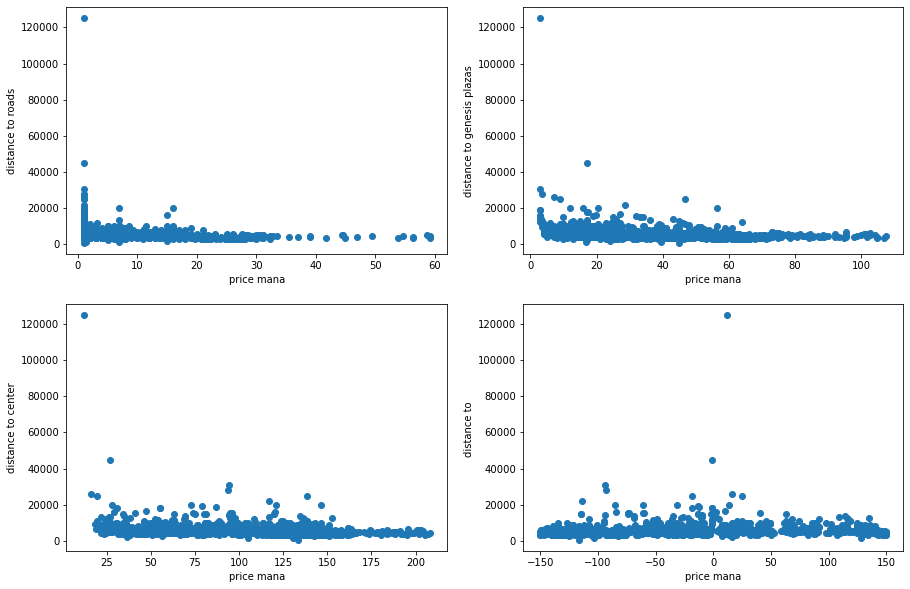

In [267]:
rows, cols = 2, 2
fig, axs = plt.subplots(rows, cols, figsize=(15,10))
axs[0,0].scatter(rcleaned_transactions.dist_road, rcleaned_transactions.price)
axs[0,1].scatter(rcleaned_transactions.dist_genesis, rcleaned_transactions.price)
axs[1,0].scatter(rcleaned_transactions.dist_center, rcleaned_transactions.price)
axs[1,1].scatter(rcleaned_transactions.y, rcleaned_transactions.price)
feature = ['roads', 'genesis plazas', 'center', '']
for i in range(rows):
    for j in range(cols):
        #axs[i, j].set_yscale('log')
        axs[i, j].set_ylabel(f'distance to {feature[i*2 + j]}')
        axs[i, j].set_xlabel('price mana')

In [1111]:
y = cleaned_transactions.norm_price_usd

In [1112]:
X = cleaned_transactions[['x','y','dist_road','dist_genesis','dist_center']]

In [1113]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import  train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lr = Ridge()  # make an instance of the model 
lr.fit(X_train, y_train)             # fit the model

y_pred = lr.predict(X_test)


In [1114]:
lr.score(X_train, y_train)

0.09601403592773172

In [1115]:
lr.score(X_test, y_test)

0.07994011636071763

In [1116]:
from sklearn.ensemble import RandomForestRegressor

In [1117]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline

In [1118]:
lr_poly = Pipeline([('standard_scaler', MinMaxScaler((-1,1))),
                    ('polynomial_trans', PolynomialFeatures(10)),
                    ('lr', Ridge())])

In [1156]:
lr_poly = Pipeline([
    ('polynomial_trans', PolynomialFeatures(2)),
    ('lr', RandomForestRegressor(max_depth=20))
])

In [1157]:
lr_poly.fit(X_train, y_train)
lr_poly.score(X_train, y_train)

0.8752483446215507

In [1158]:
lr_poly.score(X_test, y_test)

0.5127665615742123

In [1159]:
y_pred = lr_poly.predict(X_test)

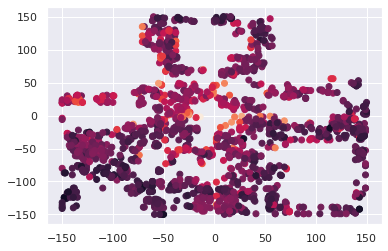

In [1160]:
plt.scatter(X_test.x, X_test.y, c=y_pred, norm=LogNorm())

In [1161]:
from sklearn import metrics

print("Mean absolute error:", metrics.mean_absolute_error(y_test, y_pred))
print("Mean squared error:", metrics.mean_squared_error(y_test, y_pred))
print("R^2:", metrics.r2_score(y_test, y_pred))

Mean absolute error: 0.2414235499952725
Mean squared error: 0.18184842159990192
R^2: 0.5127665615742123


In [1162]:
x, y = np.linspace(-150,150,301), np.linspace(-150,150,301)
X,Y = np.meshgrid(x,y)
X = X.flatten()
Y = Y.flatten()
R = np.sqrt(X**2 + Y**2)
valid_parcels = set(XY) - set(road_parcels) - set(genesis_parcels)
XY = [i for i in zip(X,Y)]
#X = [i[0] for i in valid_parcels]
#Y = [i[1] for i in valid_parcels]

In [1163]:
all_parcels = pd.DataFrame({
    'x': X,
    'y': Y,
    'dist_road': calculate_dist(road_parcels, XY).flatten(),
    'dist_genesis': calculate_dist(genesis_parcels, XY).flatten(),
    'dist_center': np.sqrt(np.sum(np.array(XY)**2,1)).flatten()
})

In [1164]:
y_pred = lr_poly.predict(all_parcels)

In [1165]:
all_parcels['y_pred'] = lr_poly.predict(all_parcels)

In [1166]:
def delete_row(row):
    if (row.x, row.y) not in valid_parcels:
        row.y_pred = None
    return None
all_parcels.apply(delete_row, axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
90596    None
90597    None
90598    None
90599    None
90600    None
Length: 90601, dtype: object

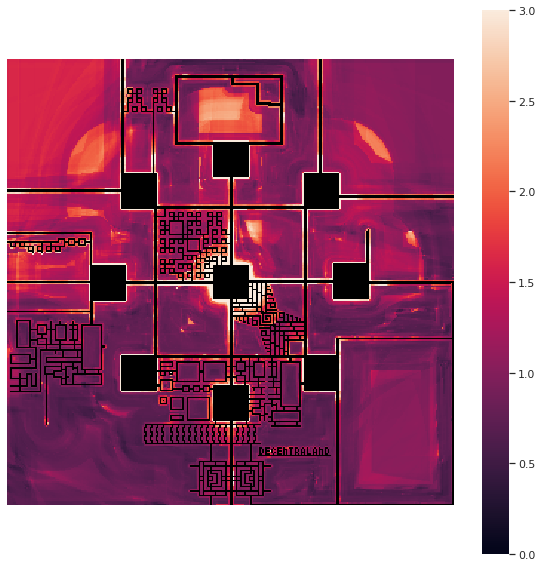

In [1167]:
plt.figure(figsize=(10,10))
g = sns.heatmap(np.flip(np.reshape(all_parcels.y_pred.values, (301,301)), axis=0), vmin=0, vmax=3, square=True)#, c = all_parcels.y_pred)#, cmap = 'jet', c=y_pred, norm=LogNorm(vmin=1000, vmax=100000))
g.set_facecolor('xkcd:black')
#plt.axis('equal')
#plt.axis('off')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,
    left=False,
    right=False,# ticks along the top edge are off
    labelbottom=False,
    labelleft=False)

In [1169]:
on_sale_parcels = pd.read_csv('on_sale_parcels.csv')

Text(0.5, 1.0, 'Asking price currently on sale parcels')

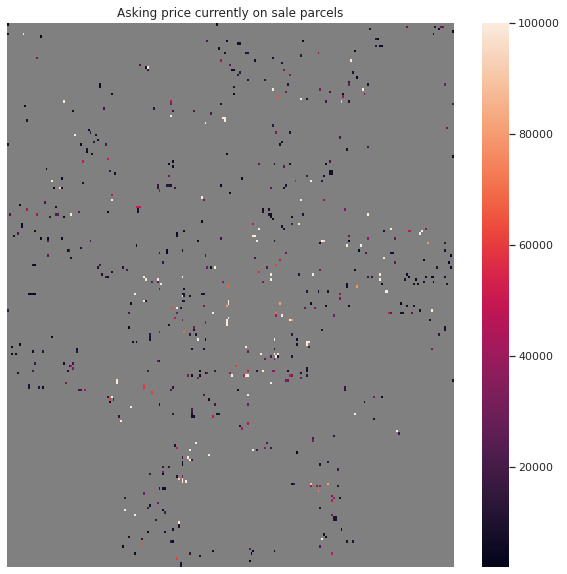

In [1178]:
plt.figure(figsize=(10,10))
sns.heatmap(on_sale_parcels.pivot("y", "x", "price"), vmin=2000, vmax=100000)
plt.gca().set_facecolor('grey')
plt.yticks([])
plt.xticks([])
plt.xlabel("")
plt.ylabel("")
plt.title("Asking price currently on sale parcels")

In [1170]:
on_sale_parcels

,id,price,updatedAt,createdAt,expiresAt,owner,nft,parcel,updatedAt_dt,x,y,parcel_id
0,0x7342d2fbf05b520afd2985fac3fb5457624033d7a513...,27979.0,1540234199,1540234199,1.669075e+09,0x5b4fd404c33190d8d58a42e8714c773def75d7f0,{'parcel': {'id': 'parcel-0xf87e31492faf9a91b0...,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2018-10-22,-23,-21,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
1,0xf7219bc9d0f69575816e790e6c554e34fe9ba0978d8e...,10000000.0,1555182518,1555182518,1.653084e+09,0x0bb75bef057da63a0ae4b25fe9adafd35cd92b87,{'parcel': {'id': 'parcel-0xf87e31492faf9a91b0...,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2019-04-13,-32,72,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
2,0x11dc7680a31fec2227388a0728592e28ef24aaa4c8b8...,10000000.0,1558294561,1558294561,1.704089e+09,0x4a5c04e65a86b49c9783a1e6ad795d0e8fdaeb6b,{'parcel': {'id': 'parcel-0xf87e31492faf9a91b0...,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2019-05-19,-55,-16,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
3,0x339f6a367908324629e85ca421466d8a66a433f984e5...,90210.0,1570853465,1570853465,1.704042e+09,0x288010917743ab792c491e6c6653f8c2445174bf,{'parcel': {'id': 'parcel-0xf87e31492faf9a91b0...,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2019-10-12,50,-111,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
4,0xa4768e8b7647947a3f8dcffb744916642516af014735...,50000000.0,1580932887,1580932887,1.678205e+09,0x32c909157c5889ed6890da21055e4cea8ea91a1c,{'parcel': {'id': 'parcel-0xf87e31492faf9a91b0...,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2020-02-05,4,-32,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
...,...,...,...,...,...,...,...,...,...,...,...,...
623,0x8cc0ceb9ead8f1c6c59881c4c72fb41496057003df61...,5000.0,1651154037,1651154037,1.653696e+09,0xe010b3bcbb3d077a82985194800227914393360a,{'parcel': {'id': 'parcel-0xf87e31492faf9a91b0...,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2022-04-28,149,-147,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
624,0xf4bf6a61522b2ba7ae51e53cdde543889dfce4033cb4...,3999.0,1651154123,1651154123,1.653696e+09,0xa01424b7540adbb792375dcf97b733a5d68ad347,{'parcel': {'id': 'parcel-0xf87e31492faf9a91b0...,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2022-04-28,56,-32,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
625,0xc19983ae99381e20960be9d13184f20ca4256e7e3270...,4400.0,1651161845,1651161845,1.653696e+09,0x5ce213893956bbf4249a7f8a079331280065eec6,{'parcel': {'id': 'parcel-0xf87e31492faf9a91b0...,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2022-04-28,-44,-28,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...
626,0xa6050303f59c7d009884b41df89710414ce4889c62a3...,4999.0,1651177419,1651177419,1.653696e+09,0x35152346a603ec69b96c6e3d8478b8d80d51aafa,{'parcel': {'id': 'parcel-0xf87e31492faf9a91b0...,{'id': 'parcel-0xf87e31492faf9a91b02ee0deaad50...,2022-04-28,-46,83,parcel-0xf87e31492faf9a91b02ee0deaad50d51d56d5...


In [ ]:
from time import sleep
while True:
     sleep(5*60)   

In [ ]:
import altair as alt

# Compute x^2 + y^2 across a 2D grid
x, y = np.meshgrid(range(-5, 5), range(-5, 5))
z = x ** 2 + y ** 2

# Convert this grid to columnar data expected by Altair
source = pd.DataFrame({'x': x.ravel(),
                     'y': y.ravel(),
                     'z': z.ravel()})

alt.Chart(source).mark_rect().encode(
    x='x:O',
    y='y:O',
    color='z:Q'
)